### Contoh kasus

Amira adalah seorang mahasiswa di `Boston University`, setelah selesai kuliah amira ingin pulang ke rumahnya di area `West End`.
Ia telah memesan sebuah uber dengan tipe `uber share`, namun ditengah perjalanan amira baru sadar bahwa ia lupa membawa dompet. setelah mengecek di sakunya, amira menemukan uang `$15`, apakah uang amira cukup untuk membayar uber tersebut?

### Batasan

- Prediksi tarif taxi / taxi online tidak dipengaruhi oleh surge multiplier
- Perjalanan pergi dan pulang dianggap sama dan rutenya sama
- beberapa fitur tambahan tidak gunakan
- masih banyak bug pada program prediksi



##### Step 1: Import Library

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

##### Step 2: Load Datasets

In [136]:
# load data
dataset = pd.read_csv('rideshare_kaggle.csv')

#load 5 data teratas
dataset.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


In [137]:
# cek nama columns
dataset.columns

Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperat

In [138]:
# membuat dataset baru berdasarkan data yang dibutuhkan
df = dataset[['distance','product_id', 'price']]
df

,distance,product_id,price
0,0.44,lyft_line,5.0
1,0.44,lyft_premier,11.0
2,0.44,lyft,7.0
3,0.44,lyft_luxsuv,26.0
4,0.44,lyft_plus,9.0
...,...,...,...
693066,1.00,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,13.0
693067,1.00,55c66225-fbe7-4fd5-9072-eab1ece5e23e,9.5
693068,1.00,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,NaN
693069,1.00,6d318bcc-22a3-4af6-bddd-b409bfce1546,27.0


##### Step 3: Data Cleaning

In [139]:
# memuat nama unik pada column product_id
df.product_id.unique()

array(['lyft_line', 'lyft_premier', 'lyft', 'lyft_luxsuv', 'lyft_plus',
       'lyft_lux', '6f72dfc5-27f1-42e8-84db-ccc7a75f6969',
       '6c84fd89-3f11-4782-9b50-97c468b19529',
       '55c66225-fbe7-4fd5-9072-eab1ece5e23e',
       '9a0e7b09-b92b-4c41-9779-2ad22b4d779d',
       '6d318bcc-22a3-4af6-bddd-b409bfce1546',
       '997acbb5-e102-41e1-b155-9df7de0a73f2',
       '8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a'], dtype=object)

In [140]:
# mengelompokkan data berdasarkan product_id dan name untuk mengecek value yang akan diganti

dataset.groupby(['product_id', 'name'])['product_id'].size()

product_id                            name        
55c66225-fbe7-4fd5-9072-eab1ece5e23e  UberX           55094
6c84fd89-3f11-4782-9b50-97c468b19529  Black           55095
6d318bcc-22a3-4af6-bddd-b409bfce1546  Black SUV       55096
6f72dfc5-27f1-42e8-84db-ccc7a75f6969  UberXL          55096
8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a  Taxi            55095
997acbb5-e102-41e1-b155-9df7de0a73f2  UberPool        55091
9a0e7b09-b92b-4c41-9779-2ad22b4d779d  WAV             55096
lyft                                  Lyft            51235
lyft_line                             Shared          51233
lyft_lux                              Lux Black       51235
lyft_luxsuv                           Lux Black XL    51235
lyft_plus                             Lyft XL         51235
lyft_premier                          Lux             51235
Name: product_id, dtype: int64

    - setelah dicek dan ditelusuri, kode atau value tersebut sebenarnya adalah nama produk dari uber dan taxi

In [141]:
# mengubah nama product_id yang tidak sesuai menjadi nama yang baru

df.product_id = np.where(df.product_id == '8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a', 'taxi', df['product_id'] )
df.product_id = np.where(df.product_id == '55c66225-fbe7-4fd5-9072-eab1ece5e23e', 'uber', df['product_id'] )
df.product_id = np.where(df.product_id == '6c84fd89-3f11-4782-9b50-97c468b19529', 'uber_lux', df['product_id'] )
df.product_id = np.where(df.product_id == '6d318bcc-22a3-4af6-bddd-b409bfce1546', 'uber_luxsuv', df['product_id'] )
df.product_id = np.where(df.product_id == '6f72dfc5-27f1-42e8-84db-ccc7a75f6969', 'uber_plus', df['product_id'] )
df.product_id = np.where(df.product_id == '997acbb5-e102-41e1-b155-9df7de0a73f2', 'uber_share', df['product_id'] )
df.product_id = np.where(df.product_id == '9a0e7b09-b92b-4c41-9779-2ad22b4d779d', 'uber_wav', df['product_id'] )

C:\Users\RIZA\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [142]:
# cek info dasar
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   distance    693071 non-null  float64
 1   product_id  693071 non-null  object 
 2   price       637976 non-null  float64
dtypes: float64(2), object(1)
memory usage: 15.9+ MB


    terlihat bahwa fitur distance memiliki string type, sehingga harus diganti menjadi float

In [143]:
# mengubah tipe data dari distance menjadi float

df = df.astype({"distance": float, "product_id": str})

# membulatkan satuan distance menjadi 1 angka dibelakang koma

df.distance = np.around(df.distance, decimals=1)

In [144]:
# cek missing value
df.isnull().sum()

distance          0
product_id        0
price         55095
dtype: int64

In [145]:
df[
    (df['product_id'] == 'taxi')
].isnull().sum()

distance          0
product_id        0
price         55095
dtype: int64

    - terdapat 55095 missing value dari 693071 total data
    - semua data tersebut adalah data dari taxi yang mana tidak memiliki data price sama sekali
    - dikarenakan kurangya informasi mengenai data price khususnya taksi, maka data tersebut akan dihapus

In [146]:
# menghapus missing value
df.dropna(inplace=True)

# mengubah nomor index menjadi berurutan
df.reset_index(drop=True, inplace=True)

In [147]:
# cek ukuran / jumlah data dari dataset yang tersisa
df.shape

(637976, 3)

##### Step 4: Eksplorasi Data

In [148]:
# cek statistic dasar

median = {
    'price' : [df.median()[1]],
    'distance' : [df.median()[0]]
}
median = pd.DataFrame(median)

median
desc = df.describe()
describe = pd.concat([median, desc], axis=0).rename(index={0:'median'})
describe

C:\Users\RIZA\AppData\Local\Temp\ipykernel_12824\894902487.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'price' : [df.median()[1]],
C:\Users\RIZA\AppData\Local\Temp\ipykernel_12824\894902487.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'distance' : [df.median()[0]]


,price,distance
median,13.500000,2.200000
count,637976.000000,637976.000000
mean,16.545125,2.188403
std,9.324359,1.136644
min,2.500000,0.000000
25%,9.000000,1.300000
50%,13.500000,2.200000
75%,22.500000,2.900000
max,97.500000,7.900000


##### Step 5: Data Preprocessing

In [149]:
# membuat fungsi untuk mengecek nilai yang menjadi outlier

def cek_outlier(df, x):
    Q1 = df[x].describe()['25%']
    Q3 = df[x].describe()['75%']
    IQR = Q3-Q1
    return df[(df[x] < Q1-1.5*IQR) | (df[x] > Q3+1.5*IQR)]



# membuat fungsi untuk menghapus nilai yang outlier

def hapus_outlier(df, x):
    
    q1 = df[x].quantile(0.25) # 25% percentile
    q3 = df[x].quantile(0.75) # 75% percentile
    
    iqr = q3-q1
    bawah  = q1-1.5*iqr
    atas = q3+1.5*iqr
    
    out = df.loc[(df[x] > bawah) & (df[x] < atas)]
    return out

C:\Users\RIZA\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\RIZA\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


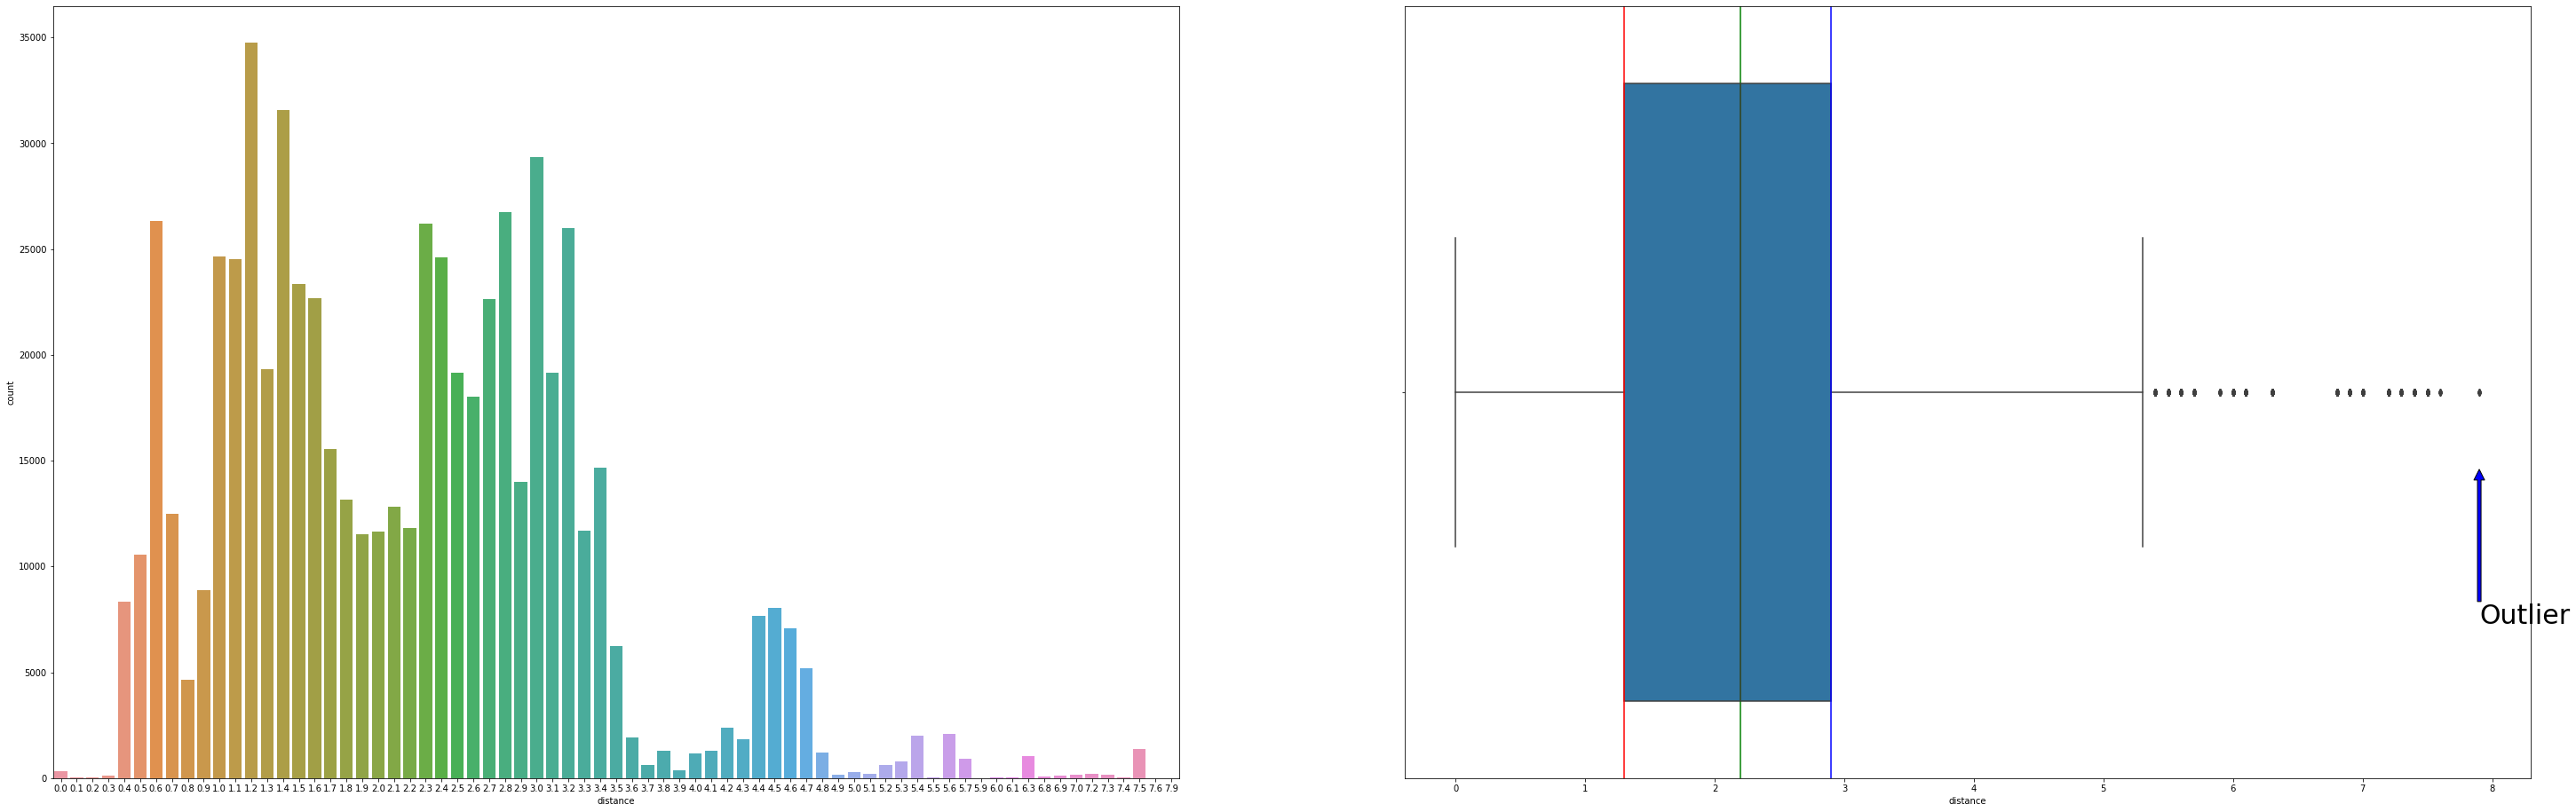

In [150]:
# cek distribusi data dari distance

f  =plt.figure(figsize=(50,16))

f.add_subplot(1,2,1)
sns.countplot(df.distance)

f.add_subplot(1,2,2)
sns.boxplot(df.distance)



plt.axvline(describe.iloc[-4,-1], color = 'red', label = 'Q1')
plt.axvline(describe.iloc[-3,-1], color = 'green', label = 'Q2')
plt.axvline(describe.iloc[-2,-1], color = 'blue', label = 'Q3')
plt.annotate('Outlier', (describe.iloc[-1,-1],0.1), xytext = (describe.iloc[-1,-1],0.3),
             arrowprops = dict(facecolor = 'blue'), fontsize = 30 )

plt.show()



In [151]:
cek_outlier(df, 'distance')

,distance,product_id,price
476,7.5,uber_wav,16.0
1811,5.6,uber_share,12.5
1812,5.6,uber_wav,15.0
1813,5.6,uber,15.0
1814,5.6,uber_lux,33.5
...,...,...,...
637915,7.4,uber_share,14.5
637916,7.4,uber_lux,36.0
637917,7.4,uber_luxsuv,49.5
637918,7.4,uber,16.0


    - dapat dilihat bahwa distribusi dari distance lebih mengarah ke skewnes condong kekanan
    - terlihat bahwa terdapat 8370 outlier
    - data outlier tersebut akan dihapus

In [152]:
# menghapus data outlier

hapus_outlier(df,'distance')

,distance,product_id,price
0,0.4,lyft_line,5.0
1,0.4,lyft_premier,11.0
2,0.4,lyft,7.0
3,0.4,lyft_luxsuv,26.0
4,0.4,lyft_plus,9.0
...,...,...,...
637971,1.0,uber_wav,9.5
637972,1.0,uber_plus,13.0
637973,1.0,uber,9.5
637974,1.0,uber_luxsuv,27.0


    jumlah data yang tersisa adalah 628814

C:\Users\RIZA\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1440x2160 with 0 Axes>

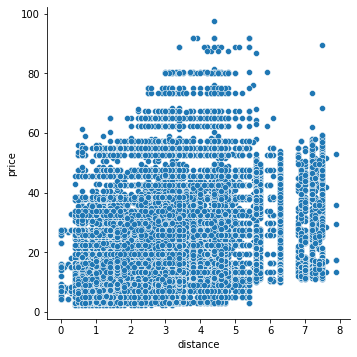

In [153]:
# cek korelasi antara distance dan price

plt.figure(figsize=(20,30))
sns.pairplot(data=df, x_vars=['distance'], y_vars=['price'], size=5)
plt.show()

In [154]:
df.corr().style.background_gradient().set_precision(2)

C:\Users\RIZA\AppData\Local\Temp\ipykernel_12824\225170090.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df.corr().style.background_gradient().set_precision(2)


,distance,price
distance,1.00,0.34
price,0.34,1.00


    - dari chart, dapat di lihat bahwa korelasi antara distance dan price condong kearah kanan atas
    - namun, berdasarkan tabel korelasi, didapatkan bahwa korelasi antara distance dan price hanya 0.34, yang 
      berarti bahwa korelasi diantara keduanya sangat kecil bahkan hampir tidak memiliki korelasi

##### Step 6: Pendefinisian Model

In [155]:
# Membuat model Multiple Linear Regression

regressor = LinearRegression()

##### Step 7: Pelatihan Model

In [156]:
# membagi data menjadi fitur dan label

x = df.drop(columns = 'price')
y = df['price'].values

In [157]:
# proses encoding fitur product_id dengan metode one-hot encoding

encoded = pd.get_dummies(x, prefix='product_id')
encoded

,distance,product_id_lyft,product_id_lyft_line,product_id_lyft_lux,product_id_lyft_luxsuv,product_id_lyft_plus,product_id_lyft_premier,product_id_uber,product_id_uber_lux,product_id_uber_luxsuv,product_id_uber_plus,product_id_uber_share,product_id_uber_wav
0,0.4,0,1,0,0,0,0,0,0,0,0,0,0
1,0.4,0,0,0,0,0,1,0,0,0,0,0,0
2,0.4,1,0,0,0,0,0,0,0,0,0,0,0
3,0.4,0,0,0,1,0,0,0,0,0,0,0,0
4,0.4,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
637971,1.0,0,0,0,0,0,0,0,0,0,0,0,1
637972,1.0,0,0,0,0,0,0,0,0,0,1,0,0
637973,1.0,0,0,0,0,0,0,1,0,0,0,0,0
637974,1.0,0,0,0,0,0,0,0,0,1,0,0,0


In [158]:
# mengambil values dari dataframe endoced

X = encoded.values
X

array([[0.4, 0. , 1. , ..., 0. , 0. , 0. ],
       [0.4, 0. , 0. , ..., 0. , 0. , 0. ],
       [0.4, 1. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 0. , 0. , ..., 0. , 1. , 0. ]])

In [159]:
# Membagi data menjadi the Training set and Test set

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [160]:
# Cek shape dari data training dan testing

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape) 

(510380, 13)
(127596, 13)
(510380,)
(127596,)


In [161]:
# melakukan training pada data train
regressor.fit(x_train, y_train)

LinearRegression()

##### Step 8: Evaluasi Model

In [162]:
# cek nilai slope / koefisien (m) dan intercept (b)

print(regressor.coef_)
print(regressor.intercept_)

[2.83404221e+00 5.05113625e+09 5.05113624e+09 5.05113626e+09
 5.05113627e+09 5.05113625e+09 5.05113626e+09 5.05113625e+09
 5.05113626e+09 5.05113627e+09 5.05113625e+09 5.05113625e+09
 5.05113625e+09]
-5051136243.764001


In [163]:
# memasukkan nilai slope dan intercept ke dictionary agar terlihat rapih

coef_dict = {
    'features' : encoded.columns,
    'coef_value' : regressor.coef_
}

coef = pd.DataFrame(coef_dict, columns = ['features', 'coef_value'])
coef

,features,coef_value
0,distance,2.834042e+00
1,product_id_lyft,5.051136e+09
2,product_id_lyft_line,5.051136e+09
3,product_id_lyft_lux,5.051136e+09
4,product_id_lyft_luxsuv,5.051136e+09
5,product_id_lyft_plus,5.051136e+09
6,product_id_lyft_premier,5.051136e+09
7,product_id_uber,5.051136e+09
8,product_id_uber_lux,5.051136e+09
9,product_id_uber_luxsuv,5.051136e+09


In [164]:
# Memprediksi hasil Test set

y_pred = regressor.predict(x_test)

In [165]:
# Cek accuracy score dari model yang telah dibuat menggunakan data test

regressor.score(x_test, y_test)

0.8945528333926609

    - terlihat bahwa akurasi dari model yang telah dibuat cukup tinggi yaitu, 89,46%

SOLUSI PERMASALAHAN

In [166]:
#fungsi untuk mengetahui perkiraan biaya dari lokasi awal ke lokasi akhir

def letsgo(source, destination, produk):
    distance_mean = dataset[
        (dataset['source'] == source) &
        (dataset['destination'] == destination)
    ].groupby(['source','destination'])['distance'].mean()
    
    
    if produk == 'lyft':
        print('biaya perjalanan dari',source, 'ke', destination, 'adalah',round(regressor.predict([[distance_mean,1,0,0,0,0,0,0,0,0,0,0,0]])[0],2),'Dollar')
    elif produk == 'lyft line':
        print('biaya perjalanan dari',source, 'ke', destination, 'adalah',round(regressor.predict([[distance_mean,0,1,0,0,0,0,0,0,0,0,0,0]])[0],2),'Dollar')
    elif produk == 'lyft lux':
        print('biaya perjalanan dari',source, 'ke', destination, 'adalah',round(regressor.predict([[distance_mean,0,0,1,0,0,0,0,0,0,0,0,0]])[0],2),'Dollar')
    elif produk == 'lyft lux suv':
        print('biaya perjalanan dari',source, 'ke', destination, 'adalah',round(regressor.predict([[distance_mean,0,0,0,1,0,0,0,0,0,0,0,0]])[0],2),'Dollar')
    elif produk == 'lyft plus':
        print('biaya perjalanan dari',source, 'ke', destination, 'adalah',round(regressor.predict([[distance_mean,0,0,0,0,1,0,0,0,0,0,0,0]])[0],2),'Dollar')
    elif produk == 'lyft premier':
        print('biaya perjalanan dari',source, 'ke', destination, 'adalah',round(regressor.predict([[distance_mean,0,0,0,0,0,1,0,0,0,0,0,0]])[0],2),'Dollar')
    elif produk == 'uber':
        print('biaya perjalanan dari',source, 'ke', destination, 'adalah',round(regressor.predict([[distance_mean,0,0,0,0,0,0,1,0,0,0,0,0]])[0],2),'Dollar')
    elif produk == 'uber lux':
        print('biaya perjalanan dari',source, 'ke', destination, 'adalah',round(regressor.predict([[distance_mean,0,0,0,0,0,0,0,1,0,0,0,0]])[0],2),'Dollar')
    elif produk == 'uber lux suv':
        print('biaya perjalanan dari',source, 'ke', destination, 'adalah',round(regressor.predict([[distance_mean,0,0,0,0,0,0,0,0,1,0,0,0]])[0],2),'Dollar')
    elif produk == 'uber plus':
        print('biaya perjalanan dari',source, 'ke', destination, 'adalah',round(regressor.predict([[distance_mean,0,0,0,0,0,0,0,0,0,1,0,0]])[0],2),'Dollar')
    elif produk == 'uber share':
        print('biaya perjalanan dari',source, 'ke', destination, 'adalah',round(regressor.predict([[distance_mean,0,0,0,0,0,0,0,0,0,0,1,0]])[0],2),'Dollar')
    elif produk == 'uber wav':
        print('biaya perjalanan dari',source, 'ke', destination, 'adalah',round(regressor.predict([[distance_mean,0,0,0,0,0,0,0,0,0,0,0,1]])[0],2),'Dollar')
    else:
        print('tidak ada tipe kendaraan seperti yang anda masukkan')

In [167]:
# Membuat tabel arah tujuan untuk bahan prediksi

daftar_tujuan = {
    'Source' : dataset.source.unique(),
    'Destination' : dataset.destination.unique()
}
PP = pd.DataFrame(daftar_tujuan, columns = ['Source', 'Destination'])

In [168]:
# Membuat dataframe untuk nama produk
Nama_produk = coef.drop(columns= 'coef_value', index= 0).reset_index(drop = True).rename(columns={'features' : 'Nama Produk' })


# Mengganti nama produk agar lebih mudah dibaca
Nama_produk['Nama Produk'] = np.where(Nama_produk['Nama Produk'] == 'product_id_lyft', 'lyft', Nama_produk['Nama Produk'])
Nama_produk['Nama Produk'] = np.where(Nama_produk['Nama Produk'] == 'product_id_lyft_line', 'lyft line', Nama_produk['Nama Produk'])
Nama_produk['Nama Produk'] = np.where(Nama_produk['Nama Produk'] == 'product_id_lyft_lux', 'lyft lux', Nama_produk['Nama Produk'])
Nama_produk['Nama Produk'] = np.where(Nama_produk['Nama Produk'] == 'product_id_lyft_luxsuv', 'lyft lux suv', Nama_produk['Nama Produk'])
Nama_produk['Nama Produk'] = np.where(Nama_produk['Nama Produk'] == 'product_id_lyft_plus', 'lyft plus', Nama_produk['Nama Produk'])
Nama_produk['Nama Produk'] = np.where(Nama_produk['Nama Produk'] == 'product_id_lyft_premier', 'lyft premier', Nama_produk['Nama Produk'])
Nama_produk['Nama Produk'] = np.where(Nama_produk['Nama Produk'] == 'product_id_uber', 'uber', Nama_produk['Nama Produk'])
Nama_produk['Nama Produk'] = np.where(Nama_produk['Nama Produk'] == 'product_id_uber_lux', 'uber lux', Nama_produk['Nama Produk'])
Nama_produk['Nama Produk'] = np.where(Nama_produk['Nama Produk'] == 'product_id_uber_luxsuv', 'uber lux suv', Nama_produk['Nama Produk'])
Nama_produk['Nama Produk'] = np.where(Nama_produk['Nama Produk'] == 'product_id_uber_plus', 'uber plus', Nama_produk['Nama Produk'])
Nama_produk['Nama Produk'] = np.where(Nama_produk['Nama Produk'] == 'product_id_uber_share', 'uber share', Nama_produk['Nama Produk'])
Nama_produk['Nama Produk'] = np.where(Nama_produk['Nama Produk'] == 'product_id_uber_wav', 'uber wav', Nama_produk['Nama Produk'])

In [169]:
# membuat daftar lengkap posisi awal, tujuan, dan jenis produk untuk bahan prediksi

daftar = pd.concat([PP, Nama_produk], axis=1)
daftar

,Source,Destination,Nama Produk
0,Haymarket Square,North Station,lyft
1,Back Bay,Northeastern University,lyft line
2,North End,West End,lyft lux
3,North Station,Haymarket Square,lyft lux suv
4,Beacon Hill,South Station,lyft plus
5,Boston University,Fenway,lyft premier
6,Fenway,Theatre District,uber
7,South Station,Beacon Hill,uber lux
8,Theatre District,Back Bay,uber lux suv
9,West End,North End,uber plus


## TOLONG PILIH SALAH SATU DI SETIAP KOLOM

In [170]:
letsgo('Boston University', 'West End', 'uber share')

biaya perjalanan dari Boston University ke West End adalah 11.25 Dollar


C:\Users\RIZA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
C:\Users\RIZA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


# Kesimpulan

untuk amira :

Dengan uang amira yang berjumlah 15 Dollar, dapat disimpulkan bahwa amira mempunyai cukup uang untuk membayar uber share yang dia tumpangi, dimana biaya total perjalanan amira menggunakan uber share adalah 11.25 Dollar



#
untuk peneliti :
- linear regresi digunakan untuk memprediksi variable dependen, dengan syarat semua fitur harus data numerik
- jika ada fitur dengan data kategorikal maka harus diubah menjadi numerik menggunakan metode yang tersedia salah satunya adalah dengan one hot encoding